### Q-learning

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import sys
import random
import pickle

In [16]:
def value_iteration(env, iterations=5e5, break_threshold=1e-3, gamma=0.9):
    optimal_values = { state: 0 for state in range(env.observation_space.n)}

    for _ in range(int(iterations)):

        max_threshold = -np.inf

        for state in range(env.observation_space.n):
            optimal_values_before = optimal_values[state]

            max_value = -np.inf

            for action in range(env.action_space.n):
                crt_reward = None
                crt_sum = 0

                for prob, next_state, reward, _ in env.P[state][action]:
                    if crt_reward is None:
                        crt_reward = reward
                    
                    crt_sum += prob * optimal_values[next_state]

                max_value = max(max_value, crt_reward + gamma * crt_sum)

            optimal_values[state] = max_value

            max_threshold = max(max_threshold, abs(optimal_values[state] - optimal_values_before))

        if max_threshold < break_threshold:
            break

    return optimal_values

In [17]:
def eps_greedy_policy(env, Q, state, epsilon):
    if random.uniform(0, 1) < epsilon:
        actions = list(env.P[state].keys()) 
        return random.choice(actions)
    else:
        return np.argmax(Q[state])


In [18]:
def generate_best_policy(env, Q):
    policy = { state: None for state in range(env.observation_space.n) }

    for state in range(env.observation_space.n):
        policy[state] = np.argmax(Q[state])

    return policy

In [19]:
def simulate_policy(env, Q, iterations):
    epoch_rewards = []

    policy = { state: None for state in range(env.observation_space.n) }

    for state in range(env.observation_space.n):
        policy[state] = np.argmax(Q[state])

    for i in range(iterations):
        env.reset()
        state = 0
        done = False

        total_reward = 0
        while not done:
            action = policy[state]
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            total_reward += reward
            state = next_state

        epoch_rewards.append(total_reward)
        

    return np.mean(epoch_rewards)

In [20]:
def q_learning(env, optimal_values, gamma, epsilon, alpha, iterations):
    env.reset()

    rmses = []

    Q = None
    env_name = env.unwrapped.spec.id
    if env_name == "Taxi-v3":
        Q = np.zeros((env.observation_space.n, env.action_space.n))
    else:
        Q = np.random.uniform(low=-1, high=1, size=(env.observation_space.n, env.action_space.n))

    for i in range(iterations):
        env.reset()
        state = 0

        done = False

        while not done:
            action = eps_greedy_policy(env, Q, state, epsilon)

            next_state, reward, terminated, truncated, _ = env.step(action)
            
            done = terminated or truncated

            Q[state, action] = (1- alpha) * Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state]))
            state = next_state

        crt_values = { state: None for state in range(Q.shape[0]) }

        for state in range(Q.shape[0]):
            crt_values[state] = np.max(Q[state])
        crt_rmse = np.sqrt(np.mean([(crt_values[state] - optimal_values[state])**2 for state in range(env.observation_space.n)]))
        rmses.append(crt_rmse)

    return rmses

In [21]:
def sarsa(env, optimal_values, gamma, epsilon, alpha, iterations):
    env.reset()
    rmses = []

    # Q = np.zeros((env.observation_space.n, env.action_space.n))
    Q = None
    env_name = env.unwrapped.spec.id
    if env_name == "Taxi-v3":
        Q = np.zeros((env.observation_space.n, env.action_space.n))
    else:
        Q = np.random.uniform(low=-1, high=1, size=(env.observation_space.n, env.action_space.n))

    for i in range(iterations):
        env.reset()
        state = 0
        done = False

        action = eps_greedy_policy(env, Q, state, epsilon)
        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = eps_greedy_policy(env, Q, next_state, epsilon)

            done = terminated or truncated

            Q[state, action] = (1- alpha) * Q[state, action] + alpha * (reward + gamma * Q[next_state, next_action])
            state = next_state
            action = next_action

        crt_values = { state: None for state in range(Q.shape[0]) }

        for state in range(Q.shape[0]):
            crt_values[state] = np.max(Q[state])

        rmse = 0
        for state in range(len(optimal_values)):
            rmse += (optimal_values[state] - crt_values[state])**2

        rmses.append(np.sqrt(rmse / len(optimal_values)))
    return rmses

In [22]:
def nstep_sarsa(env, optimal_values, gamma, epsilon, alpha, n, episodes):
    env.reset()
    rmses = []

    env_name = env.unwrapped.spec.id
    Q = None
    if env_name == "Taxi-v3":
        Q = np.zeros((env.observation_space.n, env.action_space.n))
    else:
        Q = np.random.uniform(low=-1, high=1, size=(env.observation_space.n, env.action_space.n))
    print(Q)
    G = np.zeros((env.observation_space.n, env.action_space.n))

    for _ in range(episodes):
        env.reset()
        state = 0
        done = False

        T = sys.maxsize
        t = 0
        action = eps_greedy_policy(env, Q, state, epsilon)
        state_action_rewards = [(state, action, 0)]
        while t < T - 1:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = False
            if terminated or truncated:
                done = True
                
            if done:
                T = t + 1
            else:
                action = eps_greedy_policy(env, Q, next_state, epsilon)

            state_action_rewards.append((next_state, action, reward))

            tau = t - n + 1

            if tau >= 0:
                G = 0
                for i in range(tau + 1, min(tau + n, T) + 1):
                    G += np.power(gamma, i - tau - 1) * state_action_rewards[i][2]

                if tau + n < T:
                    G += np.power(gamma, n) * Q[state_action_rewards[tau + n][0], state_action_rewards[tau + n][1]]

                state, action = state_action_rewards[tau][0], state_action_rewards[tau][1]
                Q[state, action] = (1- alpha) * Q[state, action] + alpha * G
            
            if tau == T - 1:
                break

            t += 1

        crt_values = { state: None for state in range(Q.shape[0]) }

        for state in range(Q.shape[0]):
            crt_values[state] = np.max(Q[state])

        rmse = 0
        for state in range(len(optimal_values)):
            rmse += (optimal_values[state] - crt_values[state])**2

        rmses.append(np.sqrt(rmse / len(optimal_values)))

    return rmses

/home/alex/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


For alpha:  0.0
iter:  0
2 -step sarsa
4 -step sarsa
8 -step sarsa
16 -step sarsa
iter:  1
2 -step sarsa
4 -step sarsa
8 -step sarsa
16 -step sarsa
iter:  2
2 -step sarsa
4 -step sarsa
8 -step sarsa
16 -step sarsa
iter:  3
2 -step sarsa
4 -step sarsa
8 -step sarsa
16 -step sarsa
iter:  4
2 -step sarsa
4 -step sarsa
8 -step sarsa
16 -step sarsa
iter:  5
2 -step sarsa
4 -step sarsa
8 -step sarsa
16 -step sarsa
iter:  6
2 -step sarsa
4 -step sarsa
8 -step sarsa
16 -step sarsa
iter:  7
2 -step sarsa
4 -step sarsa
8 -step sarsa
16 -step sarsa
iter:  8
2 -step sarsa
4 -step sarsa
8 -step sarsa
16 -step sarsa
iter:  9
2 -step sarsa
4 -step sarsa
8 -step sarsa
16 -step sarsa
iter:  10
2 -step sarsa
4 -step sarsa
8 -step sarsa
16 -step sarsa
iter:  11
2 -step sarsa
4 -step sarsa
8 -step sarsa
16 -step sarsa
iter:  12
2 -step sarsa
4 -step sarsa
8 -step sarsa
16 -step sarsa
iter:  13
2 -step sarsa
4 -step sarsa
8 -step sarsa
16 -step sarsa
iter:  14
2 -step sarsa
4 -step sarsa
8 -step sarsa
16 -

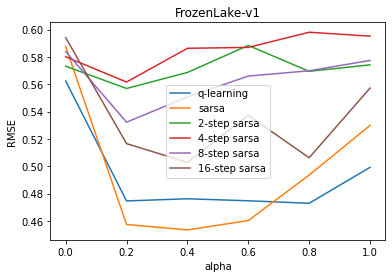

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import sys
import random
import pickle    
    
random.seed(123)
alphas = np.arange(0, 1.2, 0.20)
ns = [2, 4, 8, 16]

env_name = "FrozenLake-v1"
env = gym.make(env_name)
optimal_v = value_iteration(env)

qs_rmse_env = []
sarsa_rmse_env = []
nstep_rmse_env = [[] for _ in range(len(ns))]

for alpha in alphas:
    print("For alpha: ", alpha)
    qs_rmse = []
    sarsa_rmse = []
    nstep_rmse = [[] for _ in range(len(ns))]

    for iteration in range(20):
        print("iter: ", iteration)

        qs_rmse.append(np.mean(q_learning(env, optimal_v, 0.9, 0.1, alpha, 2000)))
        sarsa_rmse.append(np.mean(sarsa(env, optimal_v, 0.9, 0.1, alpha, 2000)))

        for n in ns:
            print(n,"-step sarsa")
            nstep_rmse[ns.index(n)].append(np.mean(nstep_sarsa(env, optimal_v, 0.9, 0.1, alpha, n, 2000)))

    qs_rmse_env.append(np.mean(qs_rmse))
    sarsa_rmse_env.append(np.mean(sarsa_rmse))
    
    for i in range(len(ns)):
        nstep_rmse_env[i].append(np.mean(nstep_rmse[i]))

plt.plot(alphas, qs_rmse_env, label="q-learning")
plt.plot(alphas, sarsa_rmse_env, label="sarsa")

for i in range(len(ns)):
    plt.plot(alphas, nstep_rmse_env[i], label="{}-step sarsa".format(ns[i]))

plt.legend()
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.xticks(alphas)
plt.title(env_name)
plt.show()
 